In [1]:
# Import required libraries

# client-related libraries
from imdclient.IMDREADER import IMDReader
import MDAnalysis as mda

# MDAnalysis libraries for analysis
from MDAnalysis.analysis.rdf import InterRDF
from MDAnalysis.analysis.rms import RMSF

# plotting and general libraries
import matplotlib.pyplot as plt
import numpy as np

# parallel processing libraries
import concurrent.futures
import threading

In [2]:
NAMD_TOPOL = "../exec-files/T3_MNN.psf"

# Enable widget mode for live interactive plots in Jupyter
%matplotlib widget

# Function to initialize the MDAnalysis universe and analyzers
def initialize_analysis(topol_path, stream_path):
    """
    Initialize MDAnalysis Universe and set up RDF and RMSF analyzers.

    Args:
        universe_path (str): Path to the topology file.
        trajectory_path (str): Path or identifier for the trajectory file.

    Returns:
        tuple: MDAnalysis universe, RDF analyzer, RMSF analyzer.
    """
    u = mda.Universe(topol_path, stream_path)
    ionText = "name POT CLA CAL SOD LIT CES IOD BRO H11 H21 H31 H41"
    ions = u.select_atoms(ionText)  # Select ions based on their names
    g = ions
    # g = u.atoms

    rdf_cutoff = 16 # Cutoff for RDF calculation

    # Initialize RDF and RMSF
    rdf = InterRDF(g, g, range=(0.0, rdf_cutoff))
    rmsf = RMSF(g)
    rdf._ts = u.trajectory.ts
    rmsf._ts = u.trajectory.ts

    # Prepare analyzers
    rdf._prepare()
    rmsf._prepare()

    return u, rdf, rmsf

In [3]:
# Function to initialize the plot for live updates
def initialize_live_plot():
    """
    Initialize a Matplotlib figure for live plotting.

    Returns:
        tuple: Figure, axes, line objects for RDF and RMSF.
    """
    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(5, 6))

    # RDF subplot
    rdf_line, = axes[0].plot([], [], label="RDF", color="blue")
    axes[0].set_title("Radial Distribution Function (RDF)")
    axes[0].set_xlabel("Distance (Å)")
    axes[0].set_ylabel("RDF")
    axes[0].set_ylim(0, 8)
    axes[0].legend()

    # RMSF subplot
    rmsf_line, = axes[1].plot([], [], label="RMSF", color="green")
    axes[1].set_title("Root Mean Square Fluctuation (RMSF)")
    axes[1].set_xlabel("Residue Index")
    axes[1].set_ylabel("RMSF (Å)")
    axes[1].legend()

    plt.tight_layout()
    return fig, axes, rdf_line, rmsf_line

In [ ]:
# Function to perform parallel calculations with live plotting
def perform_live_plotting(u, rdf, rmsf, fig, rdf_line, rmsf_line, update_frequency=10):
    """
    Perform RDF and RMSF calculations with live plot updates.

    Args:
        u (Universe): MDAnalysis universe.
        rdf (InterRDF): RDF analyzer.
        rmsf (RMSF): RMSF analyzer.
        fig (Figure): Matplotlib figure object.
        rdf_line (Line2D): Line object for RDF.
        rmsf_line (Line2D): Line object for RMSF.
        update_frequency (int): Frequency of updates to the live plot.
    """
    executor = concurrent.futures.ThreadPoolExecutor()
    count = 0

    # Initialize data containers
    rdf_bins = rdf.bins
    # rdf_data = np.zeros_like(rdf_bins)
    # rmsf_data = np.zeros(rmsf.n_atoms)

    for ts in u.trajectory:
        # Submit parallel tasks for RDF and RMSF calculations
        rdf_future = executor.submit(rdf._single_frame)

        rmsf._frame_index = count
        rmsf_future = executor.submit(rmsf._single_frame)

        # Wait for threads to complete
        rdf_future.result()
        rmsf_future.result()

        count += 1

        rdf.n_frames = count
        rdf._conclude()
        rmsf._conclude()

        # Update results
        rdf_data = np.array(rdf.results["rdf"])
        rmsf_data = np.array(rmsf.results["rmsf"])
        # rdf_data = np.array(rdf.results.rdf)
        # rmsf_data = np.array(rmsf.rmsf)

        # Live update of the plot
        if count % update_frequency == 0:
            rdf_line.set_data(rdf_bins, rdf_data)
            rmsf_line.set_data(np.arange(len(rmsf_data)), rmsf_data)

            # Adjust axis limits
            rdf_line.axes.relim()
            rdf_line.axes.autoscale_view()
            rmsf_line.axes.relim()
            rmsf_line.axes.autoscale_view()

            # Efficient redraw for Jupyter
            fig.canvas.draw_idle()

    # Finalize analyzers
    rdf.n_frames = count
    rdf._conclude()
    rmsf._conclude()

/home/athiru12/.conda/envs/imdclient-test/lib/python3.12/site-packages/MDAnalysis/analysis/rdf.py:339: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


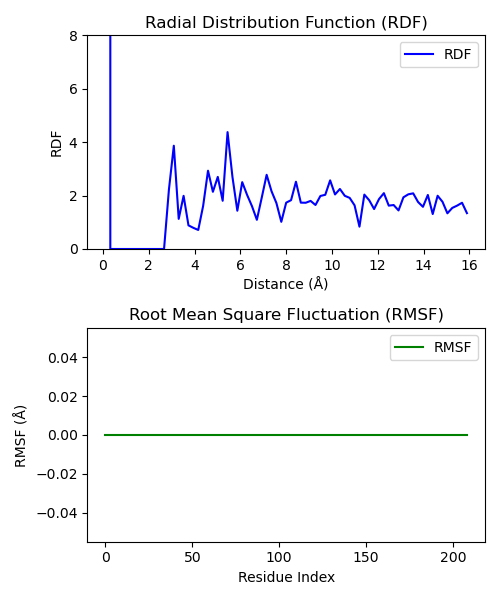

In [5]:
# Main script to execute the analysis and live plotting
if __name__ == "__main__":
    # Set paths for universe and trajectory
    topol_path, stream_path = NAMD_TOPOL, "imd://localhost:1027"

    # Initialize universe and analyzers
    u, rdf, rmsf = initialize_analysis(topol_path, stream_path)

    # Initialize live plotting
    fig, axes, rdf_line, rmsf_line = initialize_live_plot()

    # Perform calculations with live plotting
    data_thread = threading.Thread(target=perform_live_plotting, args=(u, rdf, rmsf, fig, rdf_line, rmsf_line, 1))
    data_thread.daemon = True  # Thread exits when main program ends
    data_thread.start()
    # perform_live_plotting(u, rdf, rmsf, fig, rdf_line, rmsf_line, update_frequency=1)
